### Name:

Sajith Gowthaman

### Final Capstone Project

* Predicting COVID-19 Using Deep Learning's CNN

### Introduction:




### Summary 

In [138]:
import pandas as pd
import numpy as np# forlinear algebra
from numpy import array 
import matplotlib.pyplot as plt #for plotting things
import seaborn as sns
import os
from PIL import Image
from pathlib import Path
from skimage.io import imread
import cv2
from sklearn.metrics import confusion_matrix
print(os.listdir("../chest_xray/chest_xray/train/"))

# Keras Libraries
import keras
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import Dense, Dropout, Flatten, Input, ZeroPadding2D
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras import regularizers
from keras import optimizers
from keras.models import load_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

['covid19', '.DS_Store', 'NORMAL']


In [139]:
data_dir = Path('../chest_xray/chest_xray2')
train_dir = data_dir / 'train'
val_dir = data_dir / 'val'
test_dir = data_dir / 'test'

In [140]:
# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = train_dir / 'normal/'
covid19_cases_dir = train_dir / 'covid19/'

types = ('*.jpg', '*.jpeg') # the tuple of file types
normal_cases = []
covid19_cases =[]
for files in types:
    normal_cases.extend(normal_cases_dir.glob(files))
    covid19_cases.extend(covid19_cases_dir.glob(files))

# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in covid19_cases:
    train_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_data.head()

,image,label
0,../chest_xray/chest_xray2/train/covid19/augmen...,1
1,../chest_xray/chest_xray2/train/covid19/augmen...,1
2,../chest_xray/chest_xray2/train/normal/IM-0508...,0
3,../chest_xray/chest_xray2/train/normal/NORMAL2...,0
4,../chest_xray/chest_xray2/train/covid19/augmen...,1


1    3033
0    1403
Name: label, dtype: int64


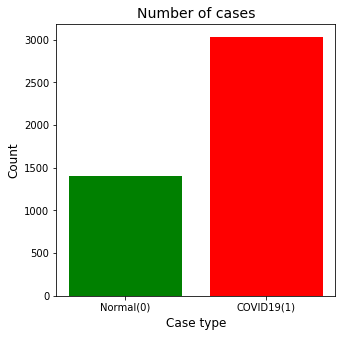

In [141]:
%matplotlib inline
# Get the counts for each class
cases_count = train_data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(5,5))
plt.bar(cases_count.index, cases_count.values, color='rg')
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'COVID19(1)'])
plt.show()

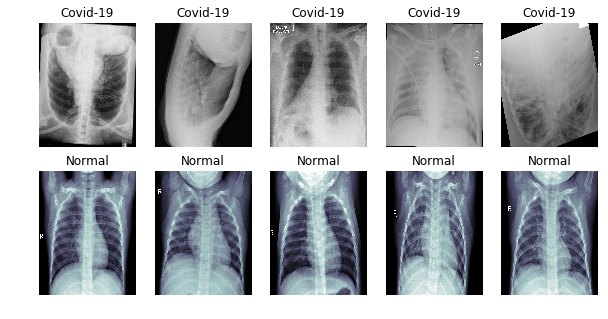

In [142]:
# Get few samples for both the classes
covid19_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = covid19_samples + normal_samples
del covid19_samples, normal_samples

# Plot the data 
f, ax = plt.subplots(2,5, figsize=(10,5))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='bone')
    if i<5:
        ax[i//5, i%5].set_title("Covid-19")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

In [143]:
#Validation dats
# Get the path to the normal and covi-19 sub-directories
normal_cases_dir = val_dir / 'normal/'
covid19_cases_dir = val_dir / 'covid19/'

types = ('*.jpg', '*.jpeg') # the tuple of file types
normal_cases = []
covid19_cases =[]
for files in types:
    normal_cases.extend(normal_cases_dir.glob(files))
    covid19_cases.extend(covid19_cases_dir.glob(files))

# List that are going to contain validation images data and the corresponding labels
valid_data = []
valid_labels = []

# Some images are in grayscale while majority of them contains 3 channels. So, if the image is grayscale, we will convert into a image with 3 channels.
# We will normalize the pixel values and resizing all the images to 224x224 

# Normal cases
for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (64,64))
    if img.shape[2] ==1: #for gray scale hxwxrgb, we are converting it to a RGB version
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)
                      
# Pneumonia cases        
for img in covid19_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (64,64))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)
    
# Convert the list into numpy arrays
valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)

print("Total number of validation examples: ", valid_data.shape)
print("Total number of labels:", valid_labels.shape)

Total number of validation examples:  (15, 64, 64, 3)
Total number of labels: (15, 2)


In [144]:
import imgaug.augmenters as iaa
# Augmentation sequence 
seq = iaa.OneOf([
    iaa.Fliplr(), # horizontal flips
    iaa.Affine(rotate=20), # roatation
    iaa.Multiply((1.2, 1.5))]) #random brightness

In [145]:
def data_gen(data, batch_size):
    # Get total number of samples in the data
    n = len(data)
    steps = n//batch_size
    
    # Define two numpy arrays for containing batch data and labels
    batch_data = np.zeros((batch_size, 64, 64, 3), dtype=np.float32)
    batch_labels = np.zeros((batch_size,2), dtype=np.float32)

    # Get a numpy array of all the indices of the input data
    indices = np.arange(n)
    
    # Initialize a counter
    i =0
    while True:
        np.random.shuffle(indices)
        # Get the next batch 
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch):
            img_name = data.iloc[idx]['image']
            label = data.iloc[idx]['label']
            
            # one hot encoding
            encoded_label = to_categorical(label, num_classes=2)
            # read the image and resize
            img = cv2.imread(str(img_name))
            img = cv2.resize(img, (64,64))
            
            # check if it's grayscale
            if img.shape[2]==1:
                img = np.dstack([img, img, img])
            
            # cv2 reads in BGR mode by default
            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # normalize the image pixels
            orig_img = img.astype(np.float32)/255.
            
            batch_data[count] = orig_img
            batch_labels[count] = encoded_label
            
            # generating more samples of the undersampled class
            if label==0 and count < batch_size-2:
                aug_img1 = seq.augment_image(img)
                aug_img2 = seq.augment_image(img)
                aug_img1 = cv2.cvtColor(aug_img1, cv2.COLOR_BGR2RGB)
                aug_img2 = cv2.cvtColor(aug_img2, cv2.COLOR_BGR2RGB)
                aug_img1 = aug_img1.astype(np.float32)/255.
                aug_img2 = aug_img2.astype(np.float32)/255.

                batch_data[count+1] = aug_img1
                batch_labels[count+1] = encoded_label
                batch_data[count+2] = aug_img2
                batch_labels[count+2] = encoded_label
                count +=2
            
            else:
                count+=1
            
            if count==batch_size-1:
                break
            
        i+=1
        yield batch_data, batch_labels
            
        if i>=steps:
            i=0

In [146]:
visible = Input(shape=(64,64,3))
conv1 = Conv2D(16, kernel_size=(3,3), activation='relu', strides=(1, 1))(visible)
conv2 = Conv2D(16, kernel_size=(3,3), activation='relu', strides=(1, 1))(conv1)
bat1 = BatchNormalization()(conv2)
zero1 = ZeroPadding2D(padding=(1, 1))(bat1)

conv3 = Conv2D(32, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.05))(zero1)
conv4 = Conv2D(32, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.05))(conv3)
bat2 = BatchNormalization()(conv4)

conv5 = Conv2D(64, kernel_size=(3,3), activation='relu',strides=(1, 1), padding='valid')(bat2)
conv6 = Conv2D(64, kernel_size=(3,3), activation='relu',strides=(1, 1), padding='valid')(conv5)
bat3 = BatchNormalization()(conv6)
pool1 = MaxPooling2D(pool_size=(2, 2))(bat3)
zero2 = ZeroPadding2D(padding=(1, 1))(pool1)

conv7 = Conv2D(128, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.01))(zero2)
conv8 = Conv2D(128, kernel_size=(2,2), activation='relu', strides=(1, 1), padding='valid')(conv7)
bat4 = BatchNormalization()(conv8)

conv9 = Conv2D(64, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.02))(bat4)
conv10 = Conv2D(64, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.02))(conv9)
bat5 = BatchNormalization()(conv10)

conv11 = Conv2D(64, kernel_size=(3,3), activation='relu', strides=(1, 1))(bat5)
conv12 = Conv2D(64, kernel_size=(3,3), activation='relu', strides=(1, 1))(conv11)
bat6 = BatchNormalization()(conv12)
pool2 = MaxPooling2D(pool_size=(2, 2))(bat6)

conv13 = Conv2D(64, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.02))(pool2)
conv14 = Conv2D(64, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.02))(conv13)
bat7 = BatchNormalization()(conv14)

conv15 = Conv2D(128, kernel_size=(3,3), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.05))(bat7)
conv16 = Conv2D(128, kernel_size=(2,2), activation='relu', strides=(1, 1), padding='valid')(conv15)
bat8 = BatchNormalization()(conv16)

flat = Flatten()(bat8)
hidden1 = Dense(32, activation='relu')(flat)
drop1 = Dropout(0.5)(hidden1)

hidden2 = Dense(32, activation='relu')(drop1)
drop2 = Dropout(0.2)(hidden2)

output = Dense(2, activation='softmax')(drop2)
model = Model(inputs=visible, outputs=output)

In [147]:
opt = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(optimizer= opt, 
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
Callbacks=[EarlyStopping(patience=3, restore_best_weights=True), 
           ReduceLROnPlateau(patience=2)]    

model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_180 (Conv2D)          (None, 62, 62, 16)        448       
_________________________________________________________________
conv2d_181 (Conv2D)          (None, 60, 60, 16)        2320      
_________________________________________________________________
batch_normalization_89 (Batc (None, 60, 60, 16)        64        
_________________________________________________________________
zero_padding2d_23 (ZeroPaddi (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_182 (Conv2D)          (None, 60, 60, 32)        4640      
_________________________________________________________________
conv2d_183 (Conv2D)          (None, 58, 58, 32)        9248

In [148]:
import h5py
# Open the VGG16 weight file
f = h5py.File('../chest_xray/chest_xray/VGG/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 'r')

# Select the layers for which you want to set weight.

w,b = f['block1_conv1']['block1_conv1_W_1:0'], f['block1_conv1']['block1_conv1_b_1:0']
model.layers[1].set_weights = [w,b]

w,b = f['block1_conv2']['block1_conv2_W_1:0'], f['block1_conv2']['block1_conv2_b_1:0']
model.layers[2].set_weights = [w,b]

w,b = f['block2_conv1']['block2_conv1_W_1:0'], f['block2_conv1']['block2_conv1_b_1:0']
model.layers[4].set_weights = [w,b]

w,b = f['block2_conv2']['block2_conv2_W_1:0'], f['block2_conv2']['block2_conv2_b_1:0']
model.layers[5].set_weights = [w,b]

f.close()
model.summary() 

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_180 (Conv2D)          (None, 62, 62, 16)        448       
_________________________________________________________________
conv2d_181 (Conv2D)          (None, 60, 60, 16)        2320      
_________________________________________________________________
batch_normalization_89 (Batc (None, 60, 60, 16)        64        
_________________________________________________________________
zero_padding2d_23 (ZeroPaddi (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_182 (Conv2D)          (None, 60, 60, 32)        4640      
_________________________________________________________________
conv2d_183 (Conv2D)          (None, 58, 58, 32)        9248

In [149]:
batch_size = 32
nb_epochs = 10

# Get a train data generator
train_data_gen = data_gen(data=train_data, batch_size=batch_size)

# Define the number of training steps
nb_train_steps = train_data.shape[0]//batch_size

print("Number of training and validation steps: {} and {}".format(nb_train_steps, len(valid_data)))

Number of training and validation steps: 138 and 15


In [150]:
# # Fit the model
history = model.fit_generator(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps,
                               validation_data=(valid_data, valid_labels),callbacks= Callbacks, verbose=1)

Epoch 1/10
138/138 [==============================] - 205s 1s/step - loss: 12.3986 - accuracy: 0.6769 - val_loss: 5.3951 - val_accuracy: 0.5333
Epoch 2/10
138/138 [==============================] - 197s 1s/step - loss: 3.2433 - accuracy: 0.7344 - val_loss: 2.1700 - val_accuracy: 0.6000
Epoch 3/10
138/138 [==============================] - 210s 2s/step - loss: 1.5520 - accuracy: 0.7901 - val_loss: 1.4054 - val_accuracy: 0.6000
Epoch 4/10
138/138 [==============================] - 200s 1s/step - loss: 1.0034 - accuracy: 0.7978 - val_loss: 1.0332 - val_accuracy: 0.6000
Epoch 5/10
138/138 [==============================] - 196s 1s/step - loss: 0.8137 - accuracy: 0.7815 - val_loss: 0.9197 - val_accuracy: 0.5333
Epoch 6/10
138/138 [==============================] - 199s 1s/step - loss: 0.6919 - accuracy: 0.8025 - val_loss: 0.7671 - val_accuracy: 0.6000
Epoch 7/10
138/138 [==============================] - 196s 1s/step - loss: 0.6428 - accuracy: 0.8028 - val_loss: 0.7303 - val_accuracy: 0.800

Run this cell for augmenting

In [2]:
# import cv2
# from skimage import io 
# from skimage.transform import rotate, AffineTransform, warp
# import random
# from skimage import img_as_ubyte
# import os
# from skimage.util import random_noise
# #Lets define functions for each operation
# def anticlockwise_rotation(image):
#     angle= random.randint(0,180)
#     return rotate(image, angle)

# def clockwise_rotation(image):
#     angle= random.randint(0,180)
#     return rotate(image, -angle)

# def h_flip(image):
#     return  np.fliplr(image)

# def v_flip(image):
#     return np.flipud(image)

# def add_noise(image):
#     return random_noise(image)

In [3]:
# transformations = {'rotate anticlockwise': anticlockwise_rotation,
#                       'rotate clockwise': clockwise_rotation,
#                       'horizontal flip': h_flip, 
#                       'vertical flip': v_flip,
#                    'adding noise': add_noise,
#                  }                #use dictionary to store names of functions 

# images_path='../chest_xray/chest_xray2/train/covid19' #path to original images
# augmented_path="../chest_xray/chest_xray2/train/aug_covid19" # path to store aumented images
# images=[] # to store paths of images from folder

# for im in os.listdir(images_path):  # read image name from folder and append its path into "images" array     
#     images.append(os.path.join(images_path,im))

# images_to_generate=3000  #you can change this value according to your requirement
# i=1                        # variable to iterate till images_to_generate

# while i<=images_to_generate:    
#     image=random.choice(images)
#     original_image = io.imread(image,plugin='matplotlib')
#     transformed_image=None
# #     print(i)
#     n = 0       #variable to iterate till number of transformation to apply
#     transformation_count = random.randint(1, len(transformations)) #choose random number of transformation to apply on the image
    
#     while n <= transformation_count:
#         key = random.choice(list(transformations)) #randomly choosing method to call
#         transformed_image = transformations[key](original_image)
#         n = n + 1
        
#     new_image_path= "%s/augmented_image_%s.jpg" %(augmented_path, i)
#     transformed_image = img_as_ubyte(transformed_image)  #Convert an image to unsigned byte format, with values in [0, 255].
#     transformed_image=cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB) #convert image to RGB before saving it
#     cv2.imwrite(new_image_path, transformed_image) # save transformed image to path
#     i =i+1

/Users/sajithgowthaman/opt/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/sajithgowthaman/opt/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [151]:
#Test data
# Get the path to the normal and covi-19 sub-directories
normal_cases_dir = test_dir / 'normal/'
covid19_cases_dir = test_dir / 'covid19/'

types = ('*.jpg', '*.jpeg') # the tuple of file types
normal_cases = []
covid19_cases =[]
for files in types:
    normal_cases.extend(normal_cases_dir.glob(files))
    covid19_cases.extend(covid19_cases_dir.glob(files))

test_data = []
test_labels = []

for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (64,64))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
                      
for img in covid19_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (64,64))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
    

test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

Total number of test examples:  (234, 64, 64, 3)
Total number of labels: (234, 2)


In [152]:
# Evaluation on test dataset
test_loss, test_score = model.evaluate(test_data, test_labels, batch_size=32)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

234/234 [==============================] - 3s 13ms/step
Loss on test set:  0.4876621469982669
Accuracy on test set:  0.9871794581413269


In [153]:
# Get predictions
preds = model.predict(test_data, batch_size=16)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(test_labels, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

(234,)
(234,)


In [154]:
# Get the confusion matrix
cm  = confusion_matrix(orig_test_labels, preds)
# Calculate Precision and Recall
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is nan
Precision of the model is 0.00


/Users/sajithgowthaman/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in long_scalars
  import sys


# Ignore below

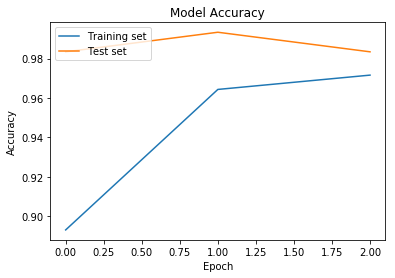

In [156]:
# Accuracy
%matplotlib inline
plt.plot(cnn_model.history['accuracy'])
plt.plot(cnn_model.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Test set'], loc='upper left')
plt.show()

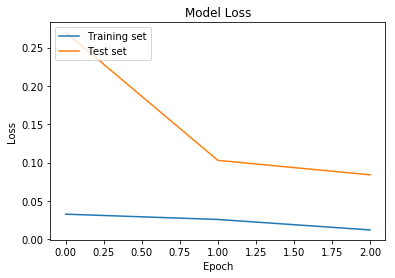

In [157]:
# Loss
plt.plot(cnn_model.history['val_loss'])
plt.plot(cnn_model.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Test set'], loc='upper left')
plt.show()

In [171]:
# Get predictions
preds = cnn.predict(test_data, batch_size=16)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(test_labels, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

(2582,)
(2582,)


MARK THE CORRECT PREDS WITH GREEN AND WRONG PREDS WITH RED- REFER COURSERA PROJECT!

In [25]:
preds= cnn.predict(test_set)
# get image name from dir, and plot.